# ART tutorial for MNIST dataset

Welcome to the **ART** tutorial for the MNIST dataset. In this tutorial, we will demonstrate how to perform a deep learning experiment using ART.

The tutorial is divided into the following sections:
1. Introduction to ART
2. Installation of required packages
3. Basic usage of ART 

## 1. Introduction to ART

ART is designed to support deep learning researchers providing a special pipeline to perform all experments in a unified way. Each experiment is defined of the following components:
- **Dataset**: Each experiment is supposed to deal with one dataset. ART supports every LightningDataModule from PyTorch Lightning, and every torch Dataset with its own dataloader.
- **Experiment**: `TODO`
- **Metrics**: `TODO`
- **Model**: While exploring different models, ART provides a unified way to define and train models. ART uses **ArtModule** that inherits from PyTorch Lightning's LightningModule. ArtModules are designed to be easily configurable and to support different model architectures.
- **Step**: `TODO`

## 2. Install dependencies

At this stage we assume that you have already installed the ART package. If not, please refer to the [ART README](https://github.com/SebChw/art#readme)

We will also need to install the following packages:

In [1]:
!pip install transformers albumentations torchvision einops

## 3. Basic usage of ART
Normally after cloning the project template you would have to implement every code template inside `exp1` on your own. We would just provide the project skeleton with all classes and functions defined, but not implemented. For this tutorial, we implemented all the functions so that you can observe how to use art.

Let's tackle this strong enemy with the art framework.

### Data preparation
First, we need to download the data. We highly recommend using Huggingface datasets wrapped into the Lightning Data Module. You can also use Torch Datasets and DataLoaders.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import datasets
from art_data import MNISTDataModule
from art.enums import INPUT, TARGET


def get_data_module(n_train=200):
    mnist_data = datasets.load_dataset("mnist")

    mnist_data = mnist_data.rename_columns({"image": INPUT, "label": TARGET})
    mnist_data['train'] = mnist_data['train'].select(range(n_train))

    return MNISTDataModule(mnist_data)


mnist_data_module = get_data_module()

/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/loggers/neptune.py:39: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune import new as neptune
Found cached dataset mnist (/home/kacper/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


  0%|          | 0/2 [00:00<?, ?it/s]

### Data analysis

In every project we encourage you to start with a deep look into the data. Currently, we are working on a tool that will help you with this task. For now, we left this part for you to implement on your own.

In [4]:
# Data analisys code goes here

### Metrics & experiment definition

1. We define the **Experiment** - the heart of art. Later we will add steps that will be performed for this particular experiment.
2. We register some metrics in **MetricCalculator** - this class performs metric calculations for all models defined by you during every step. The only need you must provide is a consistent format of returned data from different models. You can easily add exceptions - we don't want to calculate the loss for the Evaluate Baseline Step. If some metrics are expensive to calculate you add an exception and it won't be calculated. You don't need to modify the code to modify metrics behavior.

In [5]:
from art.metric_calculator import MetricCalculator
from torchmetrics import Accuracy
import torch.nn as nn
from art.step.steps import EvaluateBaselines
from art.experiment.Experiment import Experiment

exp = Experiment("exp1")

MetricCalculator.register_metric(Accuracy(task="multiclass", num_classes = 10))
MetricCalculator.register_metric(nn.CrossEntropyLoss(), exception_steps = [EvaluateBaselines])

### Baselines

Starting any Machine Learning project it is good to have some baseline for comparison. Here in `ART` we try to encourage you to try at least one of those:
* ML Baseline - Not for all problems we need Deep Learning. For tabular data or time series, there are ML models that you can take off the shelf and obtain very good results. 
* Heuristic Baseline - Sometimes you may have some intuition on how should be data regressed or classified. It is always worth to check how good these are.
* Existing solution baseline - If the problem is already solved, checking existing solutions and pointing out their drawbacks to improve on is always worth doing.


Another good habit is to separate your code into many smaller modules and don't do everything inside one gigantic Jupyter notebook. Look inside the `baselines.py` file where we have prepared everything for you.

Have you observed plenty of small functions inside each of the classes? These will create pipelines of your ArtModule.

E.g. `MlBaseline` has functions `parse_data_for_ml` and `baseline_train` that both create `ml_train_pipeline` that is defined inside art. As you become more familiar with `ART` you will be able to create your own pipelines and their building blocks.

Finally, to offer you a high level of flexibility we pass data between all stages with the use of a dictionary (This will be changed into a better structure in the future).


In [6]:
from baselines import MlBaseline, HeuristicBaseline, AlreadyExistingSolutionBaseline
from art.step.checks import CheckScoreExists
from sklearn.linear_model import LogisticRegression
from art.enums import TrainingStage
baselines = [HeuristicBaseline(), MlBaseline(
    model=LogisticRegression()), AlreadyExistingSolutionBaseline()]
baseline_names = [baseline.name for baseline in baselines]
exp.add_step(
    EvaluateBaselines(
        baselines, mnist_data_module
    ), [CheckScoreExists(["results"], Accuracy(task="multiclass", num_classes = 10), TrainingStage.TRAIN, -1, baseline) for baseline in baselines]
) # TODO In case of baselines checks must obtain model too. Think about description and name of check if these are necessary

Here we defined our 3 baselines. You can check how these are structured in `baselines.py` file. Next we create our first step that will consist of their evaluation. We always add new steps in a form: `step to be performd`, `list_of_check_to_be_performed`

### First run of the experiment

In [7]:
exp.run_all()

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warn

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                    Validate metric                     ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy-HeuristicBaseline-TRAIN-Evaluate   │                   0.5163999795913696                   │
│                       Baselines                        │                                                        │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/kacper/anaconda3/envs/audi

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                    Validate metric                     ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ MulticlassAccuracy-MlBaseline-TRAIN-Evaluate Baselines │                   0.6563000082969666                   │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                    Validate metric                     ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ MulticlassAccuracy-AlreadyExistingSolutionBaseline-TR… │                   0.9883000254631042                   │
│                       Baselines                        │                                                        │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

Alright, a lot has happened. But in the end, we have validated three baselines successfully. We can see, that the already existing solution is a very strong competitor. If results obtained by these baselines are satisfactory. 

Please visit the checkpoints folder - results of this stage are saved here. `In version 2.0 you will be able to see all the results from the dashboard`.

Having baselines we can move on and try to beat them. We will use CNN for this purpose which is defined inside `models.py`. The next step is to validate loss after network initialization. If it is off, we probably messed something up in our pipeline. We have 10 classes, so on average with random initialization loss should be -log(1/10) = 2.31


### Adding more steps

In [8]:
from models import MNISTModel
from art.step.steps import CheckLossOnInit
from art.step.checks import CheckScoreCloseTo
MetricCalculator.to("cuda")
my_model = MNISTModel()

exp.add_step(CheckLossOnInit(my_model, mnist_data_module), [CheckScoreCloseTo(nn.CrossEntropyLoss(), TrainingStage.TRAIN, 2.3, rel_tol=0.1)]) 
exp.run_all()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Step Evaluate Baselines_1 was already completed.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                    Validate metric                     ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  CrossEntropyLoss-MNISTModel-TRAIN-Check Loss On Init  │                   14.396251678466797                   │
│ MulticlassAccuracy-MNISTModel-TRAIN-Check Loss On Init │                  0.07500000298023224                   │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

Exception: Check failed for step: Check Loss On Init. Reason: Score 14.396251678466797 is not equal to 2.3

And here we are, something must be wrong in our pipeline - loss is off by big amount. Observe, two things:
1. We didn't perform baselines evaluations again this step is already passed
2. We added a check to our step. We want our loss to be close to 2.3 we failed to provide this result so we obtained an exception. We can't go further until we pass this stage.

Let's discover another feature of art that helps you to debug the code and find problems with your pipeline - Decorators.

### Decorators

`TODO`: make an introduction what is `set visualization`

In [9]:
import lovely_tensors as lt
from art.visualization_decorators import set_visualization
import logging
lt.monkey_patch()

logging.basicConfig(filename='debug_art.log', level=logging.WARNING)
def first_logging_func(data):
    logging.warning(data)


set_visualization([(my_model, "predict")], first_logging_func)
exp.run_all()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Step Evaluate Baselines_1 was already completed.


/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                    Validate metric                     ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  CrossEntropyLoss-MNISTModel-TRAIN-Check Loss On Init  │                   14.396251678466797                   │
│ MulticlassAccuracy-MNISTModel-TRAIN-Check Loss On Init │                  0.07500000298023224                   │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

Exception: Check failed for step: Check Loss On Init. Reason: Score 14.396251678466797 is not equal to 2.3

You may decorate any function in your pipeline with any logging function. Here it is a simple log, but in practice, you can do much, much more, which you will see later. Please visit the `debug_art.log` file. 

Can you spot what is wrong? Yes! We do not normalize images to the [0,1] range.

In [10]:
exp.steps[1].model.normalize_img = True
exp.run_all()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Step Evaluate Baselines_1 was already completed.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                    Validate metric                     ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  CrossEntropyLoss-MNISTModel-TRAIN-Check Loss On Init  │                   2.315009832382202                    │
│ MulticlassAccuracy-MNISTModel-TRAIN-Check Loss On Init │                  0.11500000208616257                   │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

And we've done it! We gained a little more confidence in our pipeline. Let's move further. The next step is to overfit just a single batch. If you can't do this there is for sure something wrong. From now procedure for everything else is very similar. So we import the next step and add it to our experiment with the appropriate check.

### Another step - overfitting one batch

In [11]:
from art.step.steps import OverfitOneBatch
from art.step.checks import CheckScoreLessThan

overfit_batch_step = OverfitOneBatch(MNISTModel(), mnist_data_module)
exp.add_step(overfit_batch_step, [CheckScoreLessThan(['results'], nn.CrossEntropyLoss(), TrainingStage.TRAIN, 0.01)])
exp.run_all()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Step Evaluate Baselines_1 was already completed.
Step Check Loss On Init_MNISTModel_2 was already completed.


/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Exception: Check failed for step: Overfit One Batch. Reason: Score 0.42498448491096497 is not less than 0.01

Oh no... we can't overfit. Is this an issue with the model? Maybe but at first let's see another powerful use case of art. We will debug the prediction dynamics to see how our model is evolving. We will calculate the average logit value for all images that should be classified as 1. For this purpose we create a class with memory and make it callable, later we decorate our model prediction function and casually run the experiment.

In [12]:
class EvolutionSaver:
    def __init__(self):
        self.logits = []
        self.time = 0

    def __call__(self, data):
        targets = data['target'] == 1
        logits = data['prediction']
        
        wanted_logits = logits[targets].mean(dim=0)
        for i, logit in enumerate(wanted_logits):
            self.logits.append({
                "time": self.time,
                "logit": logit.item(),
                "class": i
            })

        self.time += 1    

    def visualize(self):
        import pandas as pd
        import matplotlib.pyplot as plt
        df = pd.DataFrame(self.logits)
        df = df.pivot(index='time', columns='class', values='logit')
        df.plot()
        plt.show()

my_model = MNISTModel()
evolution_saver = EvolutionSaver()
set_visualization([(my_model, "predict")], None, evolution_saver)
overfit_batch_step.model = my_model # TODO THIS IS DONE TO RESET WEIGHTS (THIS SHOULD BE SOMEHOW DONE IN A BETTER WAY)
exp.run_all()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Step Evaluate Baselines_1 was already completed.
Step Check Loss On Init_MNISTModel_2 was already completed.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Exception: Check failed for step: Overfit One Batch. Reason: Score 0.4137640595436096 is not less than 0.01

The experiment fails, we know that. But what about the visualization?

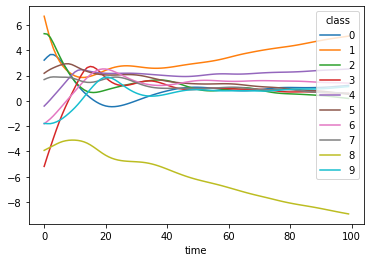

In [13]:
evolution_saver.visualize()

So, as you can see we are moving in the correct direction. 1 has the biggest logist very soon but the difference is not big enough yet - Probably we should just wait a little bit longer. Moreover, we see how powerful decorators can be. This helps us make our code more modular and fulfill the Open-Closed principle.

We can solve our problem in two ways:
* Either increase the learning rate.
* Or train for longer.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Step Evaluate Baselines_1 was already completed.
Step Check Loss On Init_MNISTModel_2 was already completed.


/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


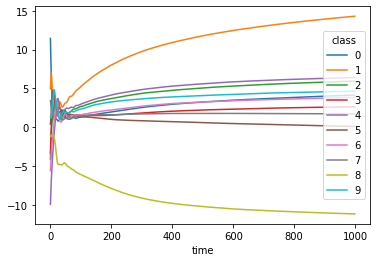

In [14]:
my_model = MNISTModel()
evolution_saver = EvolutionSaver()
set_visualization([(my_model, "predict")], None, evolution_saver)
overfit_batch_step.model = my_model
overfit_batch_step.number_of_steps = 1000
exp.run_all()
evolution_saver.visualize()

Nice! At overfitting process we'd recommend not to play with learning rate and stick with default value. It is better to just wait for a little bit longer. Now another Step can be taken. Overfitting entire training set. This is also very important as this somehow approximates our best possible score that can be achieved. If it is much below our expected result this again may indicate problems.

### Overfitting entire training set

In [15]:
from art.step.steps import Overfit
from art.step.checks import CheckScoreGreaterThan

my_model = MNISTModel()
exp = Experiment("exp1")
exp.add_step(Overfit(my_model, mnist_data_module, max_epochs=50), [CheckScoreGreaterThan(
    ['results'], nn.CrossEntropyLoss(), TrainingStage.TRAIN, 0.90)])
exp.run_all()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃               Validate metric               ┃                DataLoader 0                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  CrossEntropyLoss-MNISTModel-TRAIN-Overfit  │             0.41108280420303345             │
│ MulticlassAccuracy-MNISTModel-TRAIN-Overfit │             0.8999999761581421              │
└─────────────────────────────────────────────┴─────────────────────────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃               Validate metric               ┃                DataLoader 0                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  CrossEntropyLoss-MNISTModel-TRAIN-Overfit  │             1.1050777435302734              │
│ MulticlassAccuracy-MNISTModel-TRAIN-Overfit │             0.6305999755859375              │
└─────────────────────────────────────────────┴─────────────────────────────────────────────┘

Nice, We were able to pass the next stage in the first try. Hopefully you see another challenge that we have to face. We are able to obtain nice accuracy on the training stage. But on the validation it decreases by very much. We are overfitting the training set. For this tutorial training set was chosen to be very small so this problem was expected. But now let's try to pass the finals step of this tutorial, namely regularization. When regularizing the model you should start from the most powerful regularization technique and go to weaker. Here we will use:

1. getting more data - definitely one of the most powerful techniques. If possible always prefer this one.
2. augmentations - also very strong one

When applying augmentations to the images it is crucial to verify how do they influence the image. We again can use our decoration possibilities. *Under the hood `Regularize` class runs turn_on_regularization of ArtModule and the DataModule you use*.

You can see what we input to the network by checking `augmentations_i.png` files.

In [16]:
from torchvision.utils import save_image
from art.step.steps import Regularize

class BatchSaver:
    def __init__(self):
        self.time = 0

    def __call__(self, data):
        # We 
        if self.time < 10:
            save_image(data['input'], f'augmentations_{self.time}.png')
        self.time +=1
    

my_model = MNISTModel()
mnist_data_module = get_data_module(n_train=2000) 
set_visualization([(my_model, "predict")], BatchSaver())
exp.add_step(Regularize(my_model, mnist_data_module), [CheckScoreGreaterThan(['results'], nn.CrossEntropyLoss(), TrainingStage.TRAIN, 0.80)])
exp.run_all()

  0%|          | 0/2 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 2.7 K 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Step Overfit_MNISTModel_1 was already completed.


Sanity Checking: 0it [00:00, ?it/s]

/home/kacper/anaconda3/envs/audio-research-toolkit/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Validate metric                 ┃                  DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  CrossEntropyLoss-MNISTModel-TRAIN-Regularize  │               0.3187602758407593               │
│ MulticlassAccuracy-MNISTModel-TRAIN-Regularize │               0.911899983882904                │
└────────────────────────────────────────────────┴────────────────────────────────────────────────┘

Exception: Check failed for step: Regularize. Reason: Score 0.3187602758407593 is not greater than 0.8

Here you are! Hopefully, now you have incentive to try ART for your next data science project.